In [1]:
import numpy as np
from numpy import loadtxt
import pylab as pl
from IPython import display
from RcTorch import *
from matplotlib import pyplot as plt
from scipy.integrate import odeint
%matplotlib inline

In [2]:
#pip install rctorch==0.7


In [3]:
#this method will ensure that the notebook can use multiprocessing on jupyterhub or any other linux based system.
try:
    mp.set_start_method("spawn")
except:
    pass
torch.set_default_tensor_type(torch.FloatTensor)
%matplotlib inline

In [4]:
#helper functions
def pltTr(x,y,clr='cyan', mark='o'):
    plt.plot(x.detach().numpy(), y.detach().numpy(),
             marker=mark, color=clr, markersize=8, label='truth', alpha = 0.9)

def pltPred(x,y,clr='red', linS='-'):
    plt.plot(x.detach().numpy(), y.detach().numpy(),
             color=clr, marker='.', linewidth=2, label='RC')
from decimal import Decimal

def convert2pd(tensor1, tensor2):
    pd_ = pd.DataFrame(np.hstack((tensor1.detach().cpu().numpy(), tensor2.detach().cpu().numpy())))
    pd_.columns = ["t", "y"]
    return pd_
'%.2E' % Decimal('40800000000.00000000000000')

def param(t,N,y0):
    f = 1 - torch.exp(-t)
    f_dot = 1 - f
    #f = t
    #f_dot=1
    return y0 + f*N

#define a reparameterization function
def reparam(t, y0 = None, N = None, dN_dt = None, t_only = False):
    f = 1 - torch.exp(-t)
    f_dot = 1 - f
    
    if t_only:
        return f, f_dot

    y = y0 + N*f 
    if dN_dt:
        ydot = dN_dt * f + f_dot * N
    else:
        ydot = None
    return y, ydot

def reparam(t, order = 1):
    exp_t = torch.exp(-t)
    
    derivatives_of_g = []
    
    g = 1 - exp_t
    
    #0th derivative
    derivatives_of_g.append(g)
    
    g_dot = 1 - g
    return g, g_dot

In [5]:
def force(X, A = 0):
    return torch.zeros_like(X)
lam =1
def hamiltonian(x, p, lam = lam):
    return (1/2)*(x**2 + p**2) + lam*x**4/4

def custom_loss(X , y, ydot, out_weights, f = force, 
                reg = True, ode_coefs = None, mean = True,
               enet_strength = None, enet_alpha = None, init_conds = None, lam = 1):
    y, p = y[:,0].view(-1,1), y[:,1].view(-1,1)
    ydot, pdot = ydot[:,0].view(-1,1), ydot[:,1].view(-1,1)
    
    #with paramization
    L =  (ydot - p)**2 + (pdot + y + lam * y**3   - force(X))**2
    
    #if mean:
    L = torch.mean(L)
    
    if reg:
        #assert False
        weight_size_sq = torch.mean(torch.square(out_weights))
        weight_size_L1 = torch.mean(torch.abs(out_weights))
        L_reg = enet_strength*(enet_alpha * weight_size_sq + (1- enet_alpha) * weight_size_L1)
        L = L + 0.1 * L_reg 

    y0, p0 = init_conds
    ham = hamiltonian(y, p)
    ham0 = hamiltonian(y0, p0)
    L_H = (( ham - ham0).pow(2)).mean()
    assert L_H >0

    L = L +  0.1 * L_H
    
    #print("L1", hi, "L_elastic", L_reg, "L_H", L_H)
    return L

In [6]:
lineW = 3
lineBoxW=2

def plot_result(esn, xtrain, v0s = [1], y0s = [1.3], plot_gt = True, loglog = False,
               ode_coefs = None, force_k = 0, fileName=None, backprop_f = None, ax = None,
               solve = None , out_weights = None, epochs = None, reg = None, gamma_cyclic = None
                      ):
    
    RC = esn
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (8, 6))       
    t_pow = 0
    for i, v0 in enumerate(v0s):
        y0 = y0s[i]
        
        train_args = {"burn_in" : int(BURN_IN), 
                      "ODE_order" : 1,
                      "force" : force,
                      "reparam_f" : reparam,
                      "init_conditions" : [float(y0), float(v0)],
                      "ode_coefs" : ode_coefs,
                      "y" : None,
                      "X" : xtrain.view(-1,1),
                      "eq_system" : True,
                      #"out_weights" : out_weights
                      }
        
        if not i:
            y, ydot = esn.fit(**train_args, SOLVE = solve, out_weights = out_weights)
            
            ode_coefs_copy = ode_coefs.copy()
            states_dict = {"s"  : RC.states.clone(),
                           "s1" : RC.states_dot.clone(), 
                           "G"  : RC.G,
                           "ex" : RC.extended_states.clone(),
                           "sb1": RC.sb1,
                           "sb" : RC.sb
                           }
            if esn.ODE_order == 2:
                            states_dict["s2"] = RC.states_dot2.clone()
                            states_dict["sb2"] = RC.sb2.clone()
            #t2 = time.perf_counter()
        else:
            y, ydot = RC.fit(preloaded_states_dict = states_dict, SOLVE = solve,
                          **train_args, out_weights = out_weights)
        if not out_weights:
            if backprop_f:
                weight_dict = backprop_f(esn, epochs = epochs,reg = reg)
                #y, ydot = esn.fit(**train_args, out_weights = weight_dict, SOLVE = False)
                y,ydot = weight_dict["y"], weight_dict["ydot"]
                esn = weight_dict["RC"]
        
        ode_coefs_copy = ode_coefs.copy()
        if ode_coefs[0] == "t**2":
            sp = esn.X**2
            t_pow = 2
            ode_coefs_copy[0] = sp
            
        def f(u, t ,lam=0,A=0,W=1):
            x,  px = u      # unpack current values of u
            derivs = [px, -x - lam*x**3 +A*np.sin(W*t)]     # you write the derivative here
            return derivs
        
        # Scipy Solver   
        def NLosc_solution(t, x0,  px0, lam=0, A=0,W=1):
            u0 = [x0, px0]
            # Call the ODE solver
            solPend = odeint(f, u0, t.cpu(), args=(lam,A,W,))
            xP = solPend[:,0];        pxP = solPend[:,1];   
            return xP, pxP

        y_truth, v_truth  = NLosc_solution(esn.X.squeeze().data,1.3,1,lam=1, A=0, W= 0) 
        
        p = y[:,1].cpu()# + v0
        yy = y[:,0].cpu()# + y0
        X = esn.X.cpu()
        
        #y_truth = odeint(ODE_numSolver,y0,np.array(esn.X.cpu().view(-1,)))
        if y0==1:
            extraWidth = 2; color = 'k'
        else: extraWidth=0; color = 'b'
        
        if not i:
            ax.plot(X, yy, color, linewidth=lineW+extraWidth, label = "x_hat", color = "blue" )
            ax.plot(X, p, color, linewidth=lineW+extraWidth, label = "p_hat", color = "red" )
           
            #ax.plot(X, torch.cos(X),'--', linewidth=lineW, alpha=0.85, label = "p_gt", color = "red")
            #ax.plot(X, torch.sin(X),'--', linewidth=lineW, alpha=0.85, label = "x_gt", color = "blue")
            
            ax.plot(X, v_truth,'--', linewidth=lineW, alpha=0.85, label = "p_gt_", color = "red")
            ax.plot(X, y_truth,'--', linewidth=lineW, alpha=0.85, label = "x_gt_", color = "blue")
        else:
            ax.plot(X, yy, color, linewidth=lineW+extraWidth, color = "blue")
            ax.plot(X, p,'--r', linewidth=lineW, alpha=0.85, color = "red")
            
            ax.plot(X, v_truth,'--', linewidth=lineW, alpha=0.85, color = "red")
            ax.plot(X, y_truth,'--', linewidth=lineW, alpha=0.85, color = "blue")
        
        ## Formating Figure
        # Changing spine style
        ax = plt.gca()
        for ps in ['top','bottom','left','right']:
            ax.spines[ps].set_linewidth(lineBoxW)

        plt.xlabel(r'$t$')
        plt.ylabel(r'$y(t)$')
        plt.legend()
        
    return esn

def optimize_last_layer(esn, 
                        SAVE_AFTER_EPOCHS = 1,
                        epochs = 45000,
                        custom_loss = custom_loss,
                        EPOCHS_TO_TERMINATION = None,
                        f = force,
                        lr = 0.05, 
                        reg = None,
                        plott = True,
                        plot_every_n_epochs = 2000):#gamma 0.1, spikethreshold 0.07 works
    with torch.enable_grad():
        #define new_x
        new_X = esn.extended_states.detach()
        spikethreshold = esn.spikethreshold

        #force detach states_dot
        esn.states_dot = esn.states_dot.detach().requires_grad_(False)

        #define criterion
        criterion = torch.nn.MSELoss()

        #assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad
        #assert not new_X.requires_grad

        #define previous_loss (could be used to do a convergence stop)
        previous_loss = 0

        #define best score so that we can save the best weights
        best_score = 0

        #define the optimizer
        optimizer = optim.Adam(esn.parameters(), lr = lr)

        #optimizer = torch.optim.SGD(model.parameters(), lr=100)
        if esn.gamma_cyclic:
            cyclic_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 10**-6, 0.01,
                                            gamma = esn.gamma_cyclic,#0.9999,
                                            mode = "exp_range", cycle_momentum = False)

        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=esn.gamma)
        lrs = []

        #define the loss history
        loss_history = []

        if plott:
          #use pl for live plotting
          fig, ax = pl.subplots(1,3, figsize = (16,4))

        t = esn.X#.view(*N.shape).detach()
        g, g_dot = esn.G
        y0  = esn.init_conds[0]

        flipped = False
        flipped2 = False
        pow_ = -4
        floss_last = 0


        try:
            assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad
        except:
            esn.LinOut.weight.requires_grad_(True)
            esn.LinOut.bias.requires_grad_(True)

        #bail

        #begin optimization loop
        for e in range(epochs):

            optimizer.zero_grad()

            N = esn.forward( esn.extended_states )
            N_dot = esn.calc_Ndot(esn.states_dot)

            y = g *N 

            ydot = g_dot * N + g * N_dot

            y[:,0] = y[:,0] + esn.init_conds[0]
            y[:,1] = y[:,1] + esn.init_conds[1]

            assert N.shape == N_dot.shape, f'{N.shape} != {N_dot.shape}'

            #assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad

            #total_ws = esn.LinOut.weight.shape[0] + 1
            #weight_size_sq = torch.mean(torch.square(esn.LinOut.weight))

            loss = custom_loss(esn.X, y, ydot, esn.LinOut.weight, reg = reg, ode_coefs = esn.ode_coefs,
                    init_conds = esn.init_conds, enet_alpha= esn.enet_alpha, enet_strength = esn.enet_strength)
            loss.backward()
            optimizer.step()
            if esn.gamma_cyclic and e > 100 and e <5000:
                cyclic_scheduler.step()
                lrs.append(optimizer.param_groups[0]["lr"])


            floss = float(loss)
            loss_history.append(floss)

            if e == 10**3:
                if floss > 10**(5):
                    EPOCHS_TO_TERMINATION = e + 50

            if e == 10**4:
                if floss > 10**(2.5):
                    EPOCHS_TO_TERMINATION = e + 50
                    
            if e > 0:
                loss_delta = float(np.log(floss_last) - np.log(floss)) 
                if loss_delta > esn.spikethreshold:# or loss_delta < -3:
                    lrs.append(optimizer.param_groups[0]["lr"])
                    scheduler.step()


            if not e and not best_score:
                best_bias, best_weight, best_fit = esn.LinOut.bias.detach(), esn.LinOut.weight.detach(), y.clone()

            if e > SAVE_AFTER_EPOCHS:
                if not best_score:
                    best_score = min(loss_history)
                if floss < best_score:  
                    best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()
                    best_score = float(loss)
                    best_fit = y.clone()
                    best_ydot = ydot.clone()
            # else:
            #     if floss < best_score:
            #         best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()
            #         best_score = float(loss)
            #         best_fit = y.clone()
            #         best_ydot = ydot.clone()

            if e >= EPOCHS_TO_TERMINATION:
                return {"weights": best_weight, "bias" : best_bias, "y" : best_fit, 
                      "loss" : {"loss_history" : loss_history},  "best_score" : torch.tensor(best_score),
                      "RC" : esn}
            floss_last = floss
            if plott and e:

                if e % plot_every_n_epochs == 0:
                    for param_group in optimizer.param_groups:
                        print('lr', param_group['lr'])
                    ax[0].clear()
                    logloss_str = 'Log(L) ' + '%.2E' % Decimal((loss).item())
                    delta_loss  = ' delta Log(L) ' + '%.2E' % Decimal((loss-previous_loss).item())

                    print(logloss_str + ", " + delta_loss)
                    ax[0].plot(y.detach().cpu(), label = "exact")
                    ax[0].set_title(f"Epoch {e}" + ", " + logloss_str)
                    ax[0].set_xlabel("t")

                    ax[1].set_title(delta_loss)
                    ax[1].plot(N_dot.detach().cpu())
                    #ax[0].plot(y_dot.detach(), label = "dy_dx")
                    ax[2].clear()
                    #weight_size = str(weight_size_sq.detach().item())
                    #ax[2].set_title("loss history \n and "+ weight_size)

                    ax[2].loglog(loss_history)
                    ax[2].set_xlabel("t")

                    [ax[i].legend() for i in range(3)]
                    previous_loss = loss.item()

                    #clear the plot outputt and then re-plot
                    display.clear_output(wait=True) 
                    display.display(pl.gcf())


        return {"weights": best_weight, "bias" : best_bias, "y" : best_fit, "ydot" : best_ydot, 
              "loss" : {"loss_history" : loss_history}, "best_score" : torch.tensor(best_score),
              "RC" : esn}



In [7]:
#y0s = array([-1.  , -0.25,  0.5 ,  1.25])
torch.set_default_dtype(torch.float32)

In [8]:
log_vars = ['connectivity', 'llambda', 'llambda2', 'noise', 'regularization', 'dt', 'enet_strength']

#trained to 20*pi
hps = {'dt': 0.001,
       'n_nodes': 500,
       'connectivity': 0.019946997092875757,
       'spectral_radius': 2.4289157390594482,
       'regularization': 49.04219249279563,
       'leaking_rate': 0.0032216429244726896,
       'bias': 0.3808490037918091,
       'enet_alpha': 0.2040003091096878,
       'enet_strength': 0.07488961475845243,
       'spikethreshold': 0.4231834411621094,
       'gamma': .09350859373807907,
       'gamma_cyclic' : 0.9999}



for key, val in hps.items():
    if key in log_vars:
        print(key, np.log10(val))
    else:
        print(key, val)

dt -3.0
n_nodes 500
connectivity -1.7001224756240845
spectral_radius 2.4289157390594482
regularization 1.6905698776245117
leaking_rate 0.0032216429244726896
bias 0.3808490037918091
enet_alpha 0.2040003091096878
enet_strength -1.1255784034729004
spikethreshold 0.4231834411621094
gamma 0.09350859373807907
gamma_cyclic 0.9999


In [9]:
BURN_IN = 500

#declare the bounds dict. See above for which variables are optimized in linear vs logarithmic space.
bounds_dict = {"connectivity" : (-2, -1.4), #(-2, -0.5), 
               "spectral_radius" : (2.2, 2.6),#(0.01, 1),
               "n_nodes" : 500,
               "regularization" : 1.69, #(-4.4, 2.6),
               "leaking_rate" : (0.00322 - 0.002, 0.00322 + 0.002),
               "dt" : -3,#-3,
               "bias": (-0.5, 0.5),
               "enet_alpha": (0.18, 0.22), #(0,1.0),
               "enet_strength": (-1.32,-0.92),
               "spikethreshold" : (0.35,0.45),
               "gamma" : (0.08,0.12),
               "gamma_cyclic" : (float(np.log10(0.9997)), float(np.log10(0.99999))),#(-0.002176919254274547, 0)
               }
#set up data
x0, xf = 0, 4*np.pi
nsteps = int(abs(xf - x0)/(10**bounds_dict["dt"]))
xtrain = torch.linspace(x0, xf, nsteps, requires_grad=False).view(-1,1)
int(xtrain.shape[0])

12566

FEEDBACK: None , device: None
cpu
m,n 1 500
in_weights torch.Size([500, 1])
Model initialization and exploration run...


TypeError: '>=' not supported between instances of 'int' and 'NoneType'

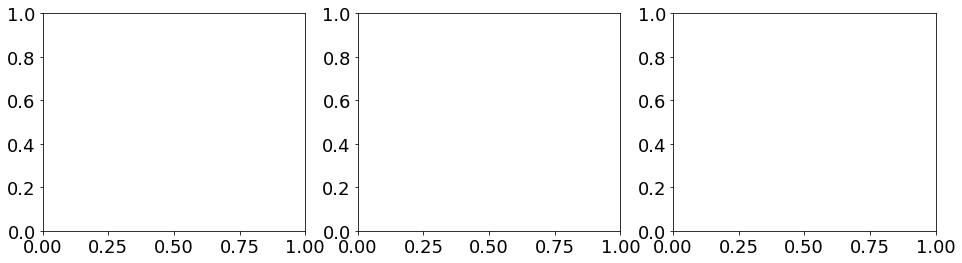

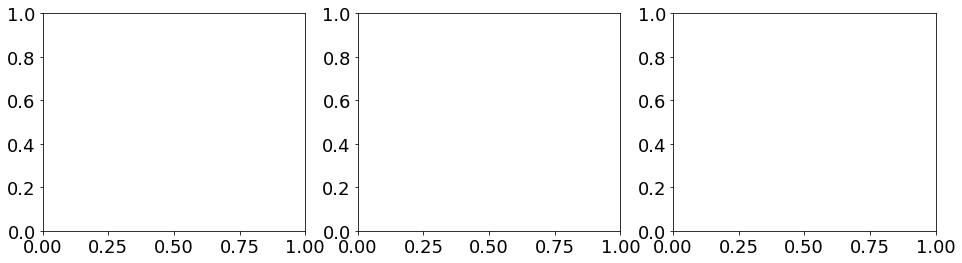

In [10]:
#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.
esn_cv = EchoStateNetworkCV(bounds = bounds_dict,
                            interactive = True, 
                            batch_size = 1, 
                            cv_samples = 1, 
                            initial_samples = 100,  #200
                            subsequence_length = int(xtrain.shape[0] * 0.98),
                            validate_fraction = 0.5,
                            random_seed = 209, 
                            success_tolerance = 10,
                            ODE_order = 1, 
                            length_min = 2 **(-8),
                            esn_burn_in = BURN_IN, 
                            log_score = True,
                            activation_function = torch.sin,
                        act_f_prime = torch.cos,
                            )
#optimize:
opt = True
if opt:
    opt_hps = esn_cv.optimize(y = None, 
                              x = xtrain.view(-1,1),
                            reparam_f = reparam, 
                            ODE_criterion = custom_loss,
                            init_conditions = [[1.1, 1.3], 1],#[[0,1], [0,1]], 
                            force = force,
                            ode_coefs = [1, 1],
                            rounds =1,
                            backprop_f = optimize_last_layer, 
                            solve =  True, 
                            eq_system = True,
                            n_outputs = 2,
                            epochs =  5000,
                            reg_type = "ham",
                            tr_score_prop = 0.2)

In [ ]:
if opt:
    opt_hps

In [ ]:
esn_cv.n_outputs

In [ ]:
#opt_hps
#new hps
hps = {'dt': 10**-2.2, #0.00630957344480193,
 'n_nodes': 500,
 'connectivity': 0.0032730501495831926,
 'spectral_radius': 8, #1.4158440828323364,
 'regularization': 1.5068021807798724,
 'leaking_rate': 0.059490688145160675,
 'bias': -0.048827290534973145}


new_hps = {'dt': 0.01,
 'n_nodes': 500,
 'connectivity': 0.0012518575764582111,
 'spectral_radius': 1.1966601610183716,
 'regularization': 16.545863672039996,
 'leaking_rate': 0.06009502336382866,
 'bias': 0.3623389005661011,
 'enet_alpha': 0.8732492327690125,
 'enet_strength': 0.011039982688091154}

new_new_hps = {'dt': 0.015848931924611134,
 'n_nodes': 500,
 'connectivity': 0.019411325024276192,
 'spectral_radius': 1.0023764371871948,
 'regularization': 0.01620633637515373,
 'leaking_rate': 0.064253069460392,
 'bias': 0.42768096923828125,
 'enet_alpha': 0.6743161678314209,
 'enet_strength': 0.8529825590176218}

#trained to 20*pi
hps = {'dt': 0.015848931924611134,
 'n_nodes': 500,
 'connectivity': 0.011412976296653454,
 'spectral_radius': 1.5883185863494873,
 'regularization': 0.00017807099501162684,
 'leaking_rate': 0.13014408946037292,
 'bias': 0.9991035461425781,
 'enet_alpha': 0.3216418921947479,
 'enet_strength': 4.858497457864491,
 'spikethreshold': 0.3982628881931305,
 'gamma': 0.09541413187980652}

#trained to 20*pi round 2
hps = {'dt': 0.015848931924611134,
 'n_nodes': 500,
 'connectivity': 0.07016350849568936,
 'spectral_radius': 1.2355562448501587,
 'regularization': 1.9761536690744939,
 'leaking_rate': 0.03428209573030472,
 'bias': 0.9089397192001343,
 'enet_alpha': 0.2660914659500122,
 'enet_strength': 3.898602924275761,
 'spikethreshold': 0.4618821144104004,
 'gamma': 0.0948069617152214}


afternoon_hps = {'dt': 0.01, #0.001, #0.01
 'n_nodes': 500,
 'connectivity': 0.020193996324265714,
 'spectral_radius': 1.418228268623352,
 'regularization': 13.826029502079747,
 'leaking_rate': 0.06767291575670242,
 'bias': -1.1795610189437866,
 'enet_alpha': 0.2708361744880676,
 'enet_strength': 0.015112827558814506,
 'spikethreshold': 0.4739722013473511,
 'gamma': 0.05922722443938255}



#esn_cv.Y_turbo.detach().cpu())
Y_turbo = esn_cv.Y_turbo.data.cpu()
plt.plot(Y_turbo)

In [ ]:
plt.plot(xtrain)

In [ ]:
# plot_result(esn, xtrain, v0s = np.array([1]), 
#             y0s = [1.3],plot_gt = True, ode_coefs = [1,1], 
#             force_k = 0,
#            backprop_f = optimize_last_layer,solve = True, epochs = 80000, reg = False)
# plt.plot(esn.states[:,1:10].detach().cpu());

In [ ]:
def fit_and_test(RC, xtrain, xtest, y0 = 1.3, v0 = 1, ode_coefs = [1,1], 
                 solve = None, epochs = None, reg = None, plott = None):
    train_args = {"burn_in" : int(BURN_IN), 
                      "ODE_order" : 1,
                      "force" : force,
                      "reparam_f" : reparam,
                      "init_conditions" : [float(y0), float(v0)],
                      "ode_coefs" : ode_coefs,
                      "y" : None,
                      "X" : xtrain.view(-1,1),
                      "eq_system" : True,
                      #"out_weights" : out_weights
                      }
    #fit
    y, ydot = RC.fit(**train_args, SOLVE = solve)#, out_weights = out_weights)
    states_dict = {"s"  : RC.states.clone(),
                   "s1" : RC.states_dot.clone(), 
                   "G"  : RC.G,
                   "ex" : RC.extended_states.clone(),
                   "sb1": RC.sb1,
                   "sb" : RC.sb
                   }
    weight_dict = optimize_last_layer(RC, epochs = epochs,reg = reg, plott = plott)
    RC = weight_dict["RC"]
    #y, ydot = esn.fit(**train_args, preloaded_states_dict = states_dict, out_weights = weight_dict, SOLVE = False)
    
    #test
    score, pred, _ = RC.test(y = torch.ones_like(xtest.to(esn.device)), X = xtest.to(esn.device), reparam = reparam, ODE_criterion = custom_loss)
    
    return esn.X.cpu().data, weight_dict["fit"].cpu().data, ydot.cpu().data, pred.cpu().data, weight_dict

def integrator_sol(esn):
    def f(u, t ,lam=0,A=0,W=1):
            x,  px = u      # unpack current values of u
            derivs = [px, -x - lam*x**3 +A*np.sin(W*t)]     # you write the derivative here
            return derivs
        
    # Scipy Solver   
    def NLosc_solution(t, x0,  px0, lam=0, A=0,W=1):
        u0 = [x0, px0]
        # Call the ODE solver
        solPend = odeint(f, u0, t.cpu(), args=(lam,A,W,))
        xP = solPend[:,0];        pxP = solPend[:,1];   
        return xP, pxP

    y_truth, v_truth = NLosc_solution(esn.X.squeeze().data,1.3,1,lam=1, A=0, W= 0) 
    
    return y_truth, v_truth

def plot_sol(X, yy, gt, xtest, pred, train_lim = None):
    plt.figure(figsize = (12, 5))
    print(yy[0,:].shape)
    plt.plot(X, yy[:,0].cpu(), label = "pred", color = "red")
    plt.plot(X, gt[0], '--', color = 'r')
    
    plt.axvline(train_lim, label = "train_limit")
    
    plt.plot(X, yy[:,1].cpu(), label = "pred", color = "b", linewidth = 5, alpha = 0.5)
    plt.plot(X, gt[1], '--', color = 'b', linewidth = 5, alpha = 0.5)
    
    plt.plot(xtest, pred, color = "green")

In [ ]:
may12hps = {'dt': 0.001,
 'n_nodes': 500,
 'connectivity': 0.019946997092875757,
 'spectral_radius': 2.4289157390594482,
 'regularization': 49.04219249279563,
 'leaking_rate': 0.0032216429244726896,
 'bias': 0.3808490037918091,
 'enet_alpha': 0.2040003091096878,
 'enet_strength': 0.07488961475845243,
 'spikethreshold': 0.4231834411621094,
 'gamma': .09350859373807907,
  'gamma_cyclic' : 0.9999}

may13hps ={'gamma_cyclic': 1,#0.9998,
 'spikethreshold': 0.25,
 'enet_alpha': 0.2,
 'dt': 0.01,
 'regularization': 13.803842646028846,
 'n_nodes': 600,
 'connectivity': 0.01344268178203971,
 'spectral_radius': 2.459860324859619,
 'leaking_rate': 0.0045151556842029095,
 #'input_scaling': 0.7782557606697083,
 'bias': -0.7429814338684082,
 'enet_strength': 0.04331694643272608,
 'gamma': 0.08337975293397903}

may15hps = {'dt': 0.001,
 'regularization': 48.97788193684461,
 'n_nodes': 500,
 'connectivity': 0.017714821964432213,
 'spectral_radius': 2.3660330772399902,
 'leaking_rate': 0.0024312976747751236,
 'bias': 0.37677669525146484,
 'enet_alpha': 0.2082211971282959,
 'enet_strength': 0.118459548397668,
 'spikethreshold': 0.43705281615257263,
 'gamma': 0.09469877928495407,
 'gamma_cyclic': 0.999860422666841}

hp_set = may15hps

In [ ]:
esn = EchoStateNetwork(**hp_set, 
                       random_state = 209, 
                       feedback = False, 
                       id_ = 10,
                       activation_f = torch.sin,
                       act_f_prime = torch.cos,
                       dtype = torch.float32, n_outputs = 2)
factor = 1#0.6*0.7
base = 10*np.pi
factor = 1.2
x0, xf, xf2 = 0, base, base*factor
nsteps = int(abs(xf - x0)/(hp_set["dt"]))
nsteps2 = int(abs(xf2 - xf)/(hp_set["dt"]))
xtrain = torch.linspace(x0, xf, nsteps, requires_grad=False).view(-1,1)
xtest = torch.cat((xtrain,xtrain+xtrain[-1]), axis = 0)[len(xtrain):]
dt1, dt2 = float(xtest[1] - xtest[0]), float(xtrain[1]- xtrain[0])
#assert dt1 == dt2, f'{dt1} != {dt2}'


xx, yy, yydot, yypred, weight_dict =  fit_and_test(esn, xtrain, xtest, epochs = 50000, reg = False, plott = True, solve = True)

In [ ]:
plt.plot(esn.states[:,  1:10]);

In [ ]:
xtrain[1]- xtrain[0], xtest[1]- xtest[0]

In [ ]:
gt = integrator_sol(esn)
plot_sol(xx, yy,gt, xtest, yypred, xf)

In [ ]:
sns.heatmap(esn.laststate.cpu().data.numpy().reshape(-1,1))

In [ ]:
xtest.shape, weight_dict["weights"].shape

In [ ]:
xtest2 = torch.linspace(x0, xf2, nsteps2, requires_grad=False).view(-1,1)

In [ ]:
esn = EchoStateNetwork(**may12hps, 
                       random_state = 209, 
                       feedback = False, 
                       id_ = 10,
                       backprop = False,
                       activation_f = torch.sin,
                       act_f_prime = torch.cos,
                       dtype = torch.float32, n_outputs = 2)

train_args = {"burn_in" : int(BURN_IN), 
              "ODE_order" : 1,
              "force" : force,
              "reparam_f" : reparam,
              "init_conditions" : [float(1.3), float(1)],
              "ode_coefs" : [1,1],
              "y" : None,
              "X" : xtrain.view(-1,1),#
              "eq_system" : True,
              "out_weights" : weight_dict,
              "SOLVE" : False
              }
y, ydot = esn.fit(**train_args)

In [ ]:
yhat = esn.predict(None, x = xtest.cuda(), continuation = True, #torch.ones_like(xtest2.cuda()), , 
                   continue_force = True)

In [ ]:
xtrain.shape

In [ ]:
plt.plot(esn.X.cpu(), y.cpu().detach())
plt.plot(xtest,yhat[1].cpu().detach())

In [ ]:
esn.X_val

In [ ]:
esn.laststate

In [ ]:
import pickle
#t2, ys, gts, ws, bs, Ls = result
plot_data = {"time": xx, 
            "ypreds" : yy,
            "extrapolation" : yypred,
            "gts" : gt}

with open('nonlinear_oscillator_plot.pickle', 'wb') as handle:
    pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('nonlinear_oscillator_plot.pickle', 'rb') as handle:
    b = pickle.load(handle)


repr_data = {"time": xx, 
       "hyper_params" : may12hps,
       "out_weights" : {"weights": [weight_dict["weights"]],
                        "bias": [weight_dict["bias"]]}, 
       "burn_in" : BURN_IN, 
       "epochs" : 30000,
       "learning_rate": 0.04,
       "loss_history" : weight_dict["loss"],
       "info" : "run on 30k epochs with both lr schedulers.",
       "v0" : 1,
       "y0" : 1.3}

with open('nonlinear_oscillator_reproduce.pickle', 'wb') as handle:
    pickle.dump(repr_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('nonlinear_oscillator_reproduce.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [ ]:
esn = EchoStateNetwork(**afternoon_hps, 
                       random_state = 209, 
                       id_ = 10,
                       activation_f = torch.sin,
                       act_f_prime = torch.cos,
                       dtype = torch.float32, n_outputs = 2)

extrapolate(esn, 0 , (np.pi * 20), (np.pi * 20)*1.2, epochs = 100000, solve = True, reg = False)

In [ ]:
orig_BO_train_len_pi_prop = 0.6*0.7
extrapolate(esn,  0, (np.pi * 4),  (np.pi * 4)*1.2, epochs = 20000)

In [ ]:
assert False
best_weights = {"weights" : esn.LinOut.weight.data, 
                "bias": esn.LinOut.bias.data}

In [ ]:
xf0,xf1, dt = 0, (np.pi * 20), esn.dt

In [ ]:
train_args = {"burn_in" : int(BURN_IN), 
              "ODE_order" : 1,
              "force" : force,
              "reparam_f" : reparam,
              "init_conditions" : [float(1.3), float(1)],
              "ode_coefs" : [1,1],
              "y" : None,
              "X" : xtrain.view(-1,1),
              "eq_system" : True,
              "out_weights" : best_weights
              }
        
y, ydot = esn.fit(**train_args, SOLVE = False)



#nsteps_test = int((xf2 - x0)/dt_)
#nsteps_test2 = int((xf2 - xf1)/dt_)

#print(f'dt = {dt_}')

#xtest = torch.linspace(x0, xf2, steps = nsteps_test, requires_grad=False).view(-1,1)
#xtest2 = torch.linspace(xf1, xf2, steps = nsteps_test2, requires_grad=False).view(-1,1)

In [ ]:
def f(u, t ,lam=0,A=0,W=1):
            x,  px = u      # unpack current values of u
            derivs = [px, -x - lam*x**3 +A*np.sin(W*t)]     # you write the derivative here
            return derivs
        
# Scipy Solver   
def NLosc_solution(t, x0,  px0, lam=0, A=0,W=1):
    u0 = [x0, px0]
    # Call the ODE solver
    solPend = odeint(f, u0, t.cpu(), args=(lam,A,W,))
    xP = solPend[:,0];        pxP = solPend[:,1];   
    return xP, pxP

y_truth, v_truth  = NLosc_solution(esn.X.squeeze().data,1.3,1,lam=1, A=0, W= 0.5) 


#p = y[:,1].cpu()# + v0
#yy = y[:,0].cpu()# + y0

In [ ]:
plt.plot((y[:,1].cpu()))
plt.plot(v_truth)

In [ ]:
x, p = esn.yfit[:,0].view(-1,1), esn.yfit[:,1].view(-1,1)
xdot, pdot = esn.ydot[:,0].view(-1,1), esn.ydot[:,1].view(-1,1)
plt.plot(custom_loss(esn.X, esn.yfit, esn.ydot, None, mean = False))
plt.plot(x, label = "x")
plt.plot(p, label = "p")
plt.legend();